# Description

This notebooks performs QA checks for CCXT Futures OHLCV data:
   - Number of NaN data points as % of total
   - Number of data points where `volume=0` as % of total

# Imports

In [1]:
import logging
import os

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import helpers.hs3 as hs3
import im_v2.ccxt.data.client as icdcl
import research_amp.cc.qa as ramccqa

/app/helpers/hparquet.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-4d3f0eff-437f-45ed-b020-0692cfbd5c03.json'
INFO  # Git
    branch_name='CmTask2188_CCXT_futures_QA'
    hash='8db0669ac'
    # Last commits:
      *   8db0669ac dan      Merge branch 'master' into CmTask2188_CCXT_futures_QA             ( 9 minutes ago) Fri Jun 24 13:35:11 2022  (HEAD -> CmTask2188_CCXT_futures_QA, origin/CmTask2188_CCXT_futures_QA)
      |\  
      | * 6d009bb19 Daniil Tikhomirov CMTask2188: Fix options (#2207)                                   (  16 hours ago) Thu Jun 23 22:11:06 2022  (origin/master, origin/HEAD, master)
      | * bb5612f77 Max Sergeychikov CMTask2190 - Extract new iteration of e-mail reaches (#2194)      (  16 hours ago) Thu Jun 23 21:25:42 2022           
# Machine info
    system=Linux
    node name=488f35b9b513
    release=5.13.0-1022-aws
    version=#24~20.04.1-Ubuntu SMP Thu Apr 7 22:10:15 UTC 2022
    machine=x86_64
    processor=x

# Configs

In [3]:
def get_cmtask2188_config() -> cconconf.Config:
    """
    Get task2188-specific config.
    """
    config = cconconf.Config()
    param_dict = {
        "data": {
            # Parameters for client initialization.
            "im_client": {
                "universe_version": "v5",
                "resample_1min": False,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"), "reorg", "historical.manual.pq"
                ),
                "partition_mode": "by_year_month",
                "dataset": "ohlcv",
                "contract_type": "futures",
                "data_snapshot": "20220620",
                "aws_profile": "ck",
            },
            # Parameters for data query.
            "read_data": {
                "start_ts": None,
                "end_ts": None,
                "columns": ["full_symbol", "close", "volume"],
                "filter_data_mode": "assert",
            },
        },
        "column_names": {
            "full_symbol": "full_symbol",
            "close_price": "close",
        },
        "stats": {
            "threshold": 30,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config

In [4]:
config = get_cmtask2188_config()
print(config)

data:
  im_client:
    universe_version: v5
    resample_1min: False
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    dataset: ohlcv
    contract_type: futures
    data_snapshot: 20220620
    aws_profile: ck
  read_data:
    start_ts: None
    end_ts: None
    columns: ['full_symbol', 'close', 'volume']
    filter_data_mode: assert
column_names:
  full_symbol: full_symbol
  close_price: close
stats:
  threshold: 30


# QA checks

Major metric for a QA check is `"bad data [%]"` which is the sum of `"volume=0 [%]"` and `"NaNs [%]"`.

In [5]:
client = icdcl.CcxtHistoricalPqByTileClient(**config["data"]["im_client"])

In [6]:
universe = client.get_universe()
universe

['binance::ADA_USDT',
 'binance::AVAX_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::DOGE_USDT',
 'binance::EOS_USDT',
 'binance::ETH_USDT',
 'binance::LINK_USDT',
 'binance::SOL_USDT',
 'coinbase::ADA_USDT',
 'coinbase::AVAX_USDT',
 'coinbase::BTC_USDT',
 'coinbase::DOGE_USDT',
 'coinbase::ETH_USDT',
 'coinbase::LINK_USDT',
 'coinbase::SOL_USDT',
 'coinbasepro::ADA_USDT',
 'coinbasepro::AVAX_USDT',
 'coinbasepro::BTC_USDT',
 'coinbasepro::DOGE_USDT',
 'coinbasepro::ETH_USDT',
 'coinbasepro::LINK_USDT',
 'coinbasepro::SOL_USDT',
 'ftx::BNB_USDT',
 'ftx::BTC_USDT',
 'ftx::DOGE_USDT',
 'ftx::ETH_USDT',
 'ftx::LINK_USDT',
 'ftx::SOL_USDT',
 'ftx::XRP_USDT',
 'gateio::ADA_USDT',
 'gateio::AVAX_USDT',
 'gateio::BNB_USDT',
 'gateio::BTC_USDT',
 'gateio::DOGE_USDT',
 'gateio::EOS_USDT',
 'gateio::ETH_USDT',
 'gateio::FIL_USDT',
 'gateio::LINK_USDT',
 'gateio::SOL_USDT',
 'gateio::XRP_USDT',
 'kucoin::ADA_USDT',
 'kucoin::AVAX_USDT',
 'kucoin::BNB_USDT',
 'kucoin::BTC_USDT',
 'k

## Binance

In [7]:
binance_universe = [
    full_symbol for full_symbol in universe if full_symbol.startswith("binance")
]
binance_universe

['binance::ADA_USDT',
 'binance::AVAX_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::DOGE_USDT',
 'binance::EOS_USDT',
 'binance::ETH_USDT',
 'binance::LINK_USDT',
 'binance::SOL_USDT']

In [8]:
binance_data = client.read_data(binance_universe, **config["data"]["read_data"])
binance_data.head(3)

WARNING * Failed assertion *
val1 - val2=['binance::SOL_USDT']
val2 - val1=[]
val1=['binance::ADA_USDT', 'binance::AVAX_USDT', 'binance::BNB_USDT', 'binance::BTC_USDT', 'binance::DOGE_USDT', 'binance::EOS_USDT', 'binance::ETH_USDT', 'binance::LINK_USDT', 'binance::SOL_USDT']
set eq
val2=['binance::ADA_USDT', 'binance::AVAX_USDT', 'binance::BNB_USDT', 'binance::BTC_USDT', 'binance::DOGE_USDT', 'binance::EOS_USDT', 'binance::ETH_USDT', 'binance::LINK_USDT']
Not all the requested symbols were retrieved
Continuing as per user request with only_warning=True


,full_symbol,close,volume
timestamp,,,
2019-09-08 17:57:00+00:00,binance::BTC_USDT,10000.0,0.001
2019-09-08 17:58:00+00:00,binance::BTC_USDT,10000.0,0.000
2019-09-08 17:59:00+00:00,binance::BTC_USDT,10000.0,0.001


In [9]:
vendor_name = "CCXT"
binance_timestamp_stats = ramccqa.get_timestamp_stats(binance_data, vendor_name)
binance_timestamp_stats

,min_timestamp,max_timestamp,days_available
binance::ADA_USDT,2020-01-31 08:01:00+00:00,2022-06-24 00:18:00+00:00,874
binance::AVAX_USDT,2020-09-23 07:00:00+00:00,2022-06-24 01:39:00+00:00,638
binance::BNB_USDT,2020-02-10 08:01:00+00:00,2022-06-24 01:39:00+00:00,864
binance::BTC_USDT,2019-09-08 17:57:00+00:00,2022-06-24 01:39:00+00:00,1019
binance::DOGE_USDT,2020-07-10 09:00:00+00:00,2022-06-24 01:39:00+00:00,713
binance::EOS_USDT,2020-01-08 08:00:00+00:00,2022-06-24 01:39:00+00:00,897
binance::ETH_USDT,2019-11-27 07:45:00+00:00,2022-06-24 01:39:00+00:00,939
binance::LINK_USDT,2020-01-17 08:00:00+00:00,2022-06-24 01:39:00+00:00,888


In [11]:
agg_level_full_symbol = ["full_symbol"]
binance_bad_data_stats = ramccqa.get_bad_data_stats(
    binance_data, agg_level_full_symbol, vendor_name
)
binance_bad_data_stats

,bad data [%],missing bars [%],volume=0 [%],NaNs [%]
binance::ADA_USDT,0.533211,0.000000,0.533211,0.0
binance::AVAX_USDT,0.044682,0.000000,0.044682,0.0
binance::BNB_USDT,0.063684,0.000000,0.063684,0.0
binance::BTC_USDT,0.031952,0.000068,0.031884,0.0
binance::DOGE_USDT,1.368758,0.000000,1.368758,0.0
binance::EOS_USDT,0.012377,0.000000,0.012377,0.0
binance::ETH_USDT,0.029042,0.000000,0.029042,0.0
binance::LINK_USDT,0.015471,0.000000,0.015471,0.0


In [12]:
agg_level_full_symbol_year_month = ["full_symbol", "year", "month"]
binance_bad_data_stats_by_year_month = ramccqa.get_bad_data_stats(
    binance_data, agg_level_full_symbol_year_month, vendor_name
)
binance_bad_data_stats_by_year_month

bad data [%]  missing bars [%]  volume=0 [%]  NaNs [%]
binance::ADA_USDT  2020 1       0.000000          0.000000      0.000000       0.0
                        2       0.476533          0.000000      0.476533       0.0
                        3       4.298835          0.000000      4.298835       0.0
                        4       6.868056          0.000000      6.868056       0.0
                        5       3.306452          0.000000      3.306452       0.0
                        6       0.032407          0.000000      0.032407       0.0
                        7       0.000000          0.000000      0.000000       0.0
                        8       0.000000          0.000000      0.000000       0.0
                        9       0.039352          0.000000      0.039352       0.0
                        10      0.002240          0.000000      0.002240       0.0
                        11      0.000000          0.000000      0.000000       0.0
                        12      0.000000          0.000000      0.000000       0.0
                   2021 1       0.000000          0.000000      0.000000       0.0
                        2       0.000000          0.000000      0.000000       0.0
                        3       0.132168          0.000000      0.132168       0.0
                        4       0.000000          0.000000      0.000000       0.0
                        5       0.000000          0.000000      0.000000       0.0
                        6       0.000000          0.000000      0.000000       0.0
                        7       0.000000          0.000000      0.000000       0.0
                        8       0.000000          0.000000      0.000000       0.0
                        9       0.000000          0.000000      0.000000       0.0
                        10      0.000000          0.000000      0.000000       0.0
                        11      0.000000          0.000000      0.000000       0.0
                        12      0.000000          0.000000      0.000000       0.0
                   2022 1       0.000000          0.000000      0.000000       0.0
                        2       0.000000          0.000000      0.000000       0.0
                        3       0.000000          0.000000      0.000000       0.0
                        4       0.000000          0.000000      0.000000       0.0
                        5       0.143369          0.000000      0.143369       0.0
                        6       0.000000          0.000000      0.000000       0.0
binance::AVAX_USDT 2020 9       0.099099          0.000000      0.099099       0.0
                        10      0.407706          0.000000      0.407706       0.0
                        11      0.129630          0.000000      0.129630       0.0
                        12      0.076165          0.000000      0.076165       0.0
                   2021 1       0.000000          0.000000      0.000000       0.0
                        2       0.000000          0.000000      0.000000       0.0
                        3       0.132168          0.000000      0.132168       0.0
                        4       0.000000          0.000000      0.000000       0.0
                        5       0.000000          0.000000      0.000000       0.0
                        6       0.000000          0.000000      0.000000       0.0
                        7       0.011201          0.000000      0.011201       0.0
                        8       0.000000          0.000000      0.000000       0.0
                        9       0.000000          0.000000      0.000000       0.0
                        10      0.000000          0.000000      0.000000       0.0
                        11      0.000000          0.000000      0.000000       0.0
                        12      0.000000          0.000000      0.000000       0.0
                   2022 1       0.000000          0.000000      0.000000       0.0
                        2       0.000000    

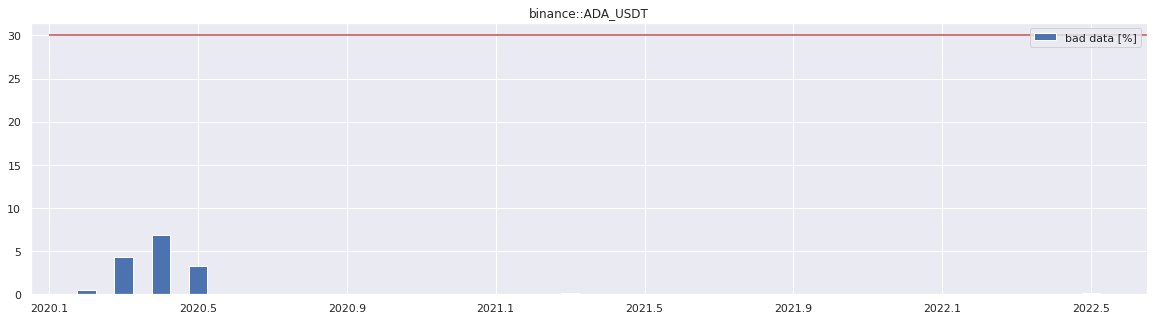

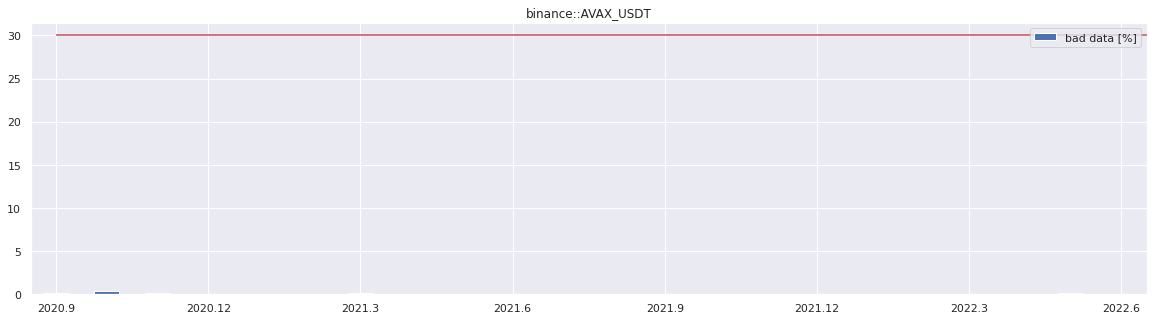

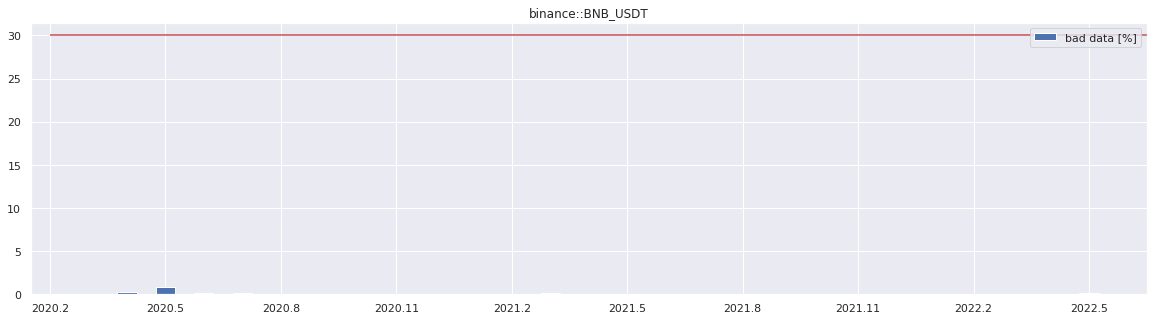

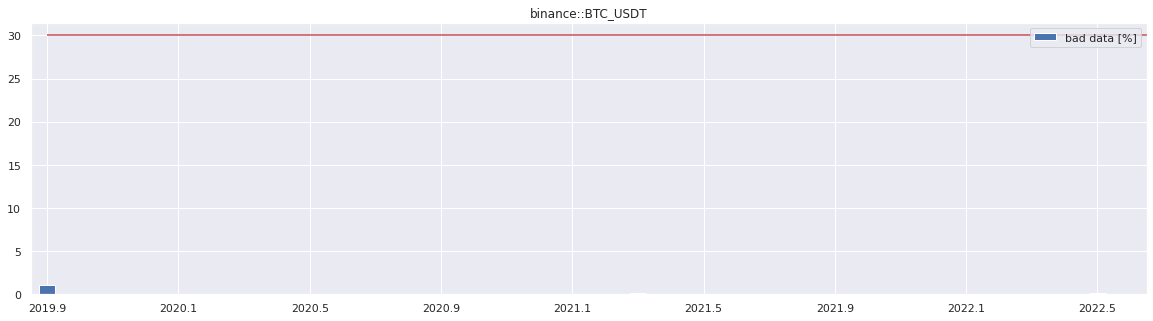

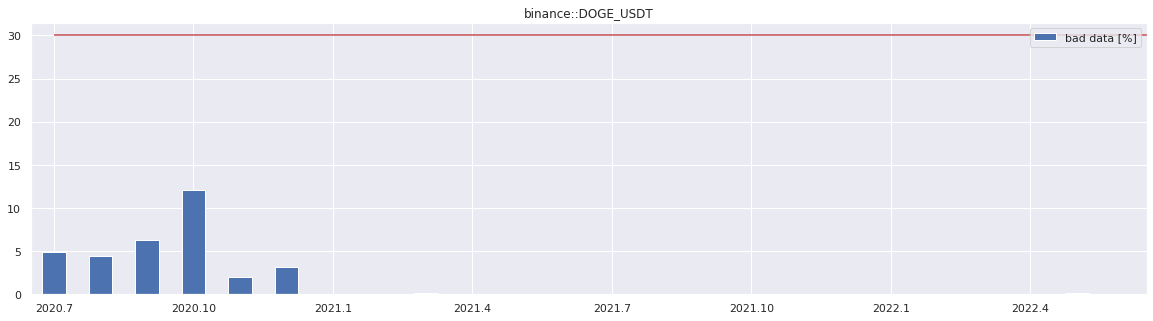

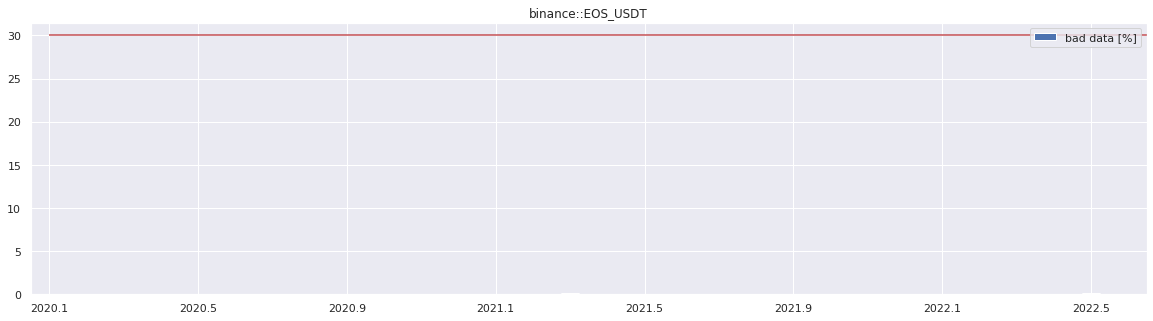

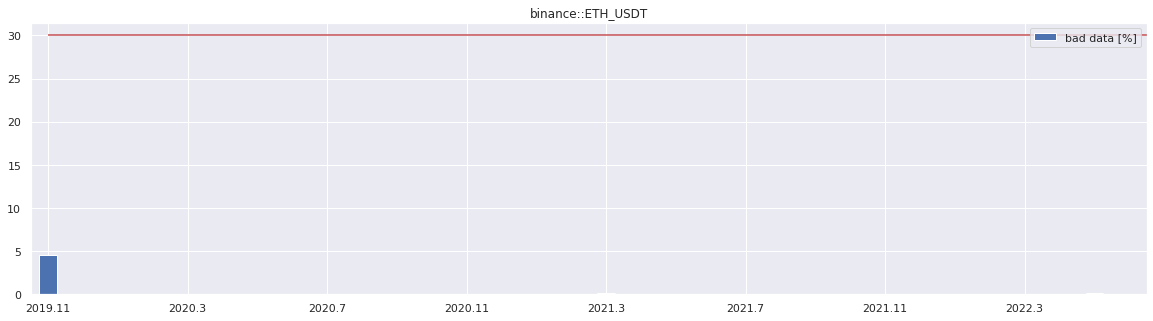

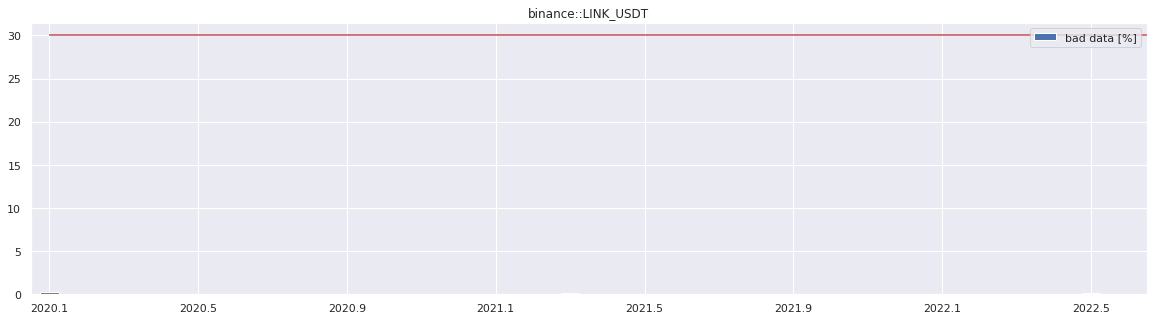

In [13]:
_ = ramccqa.plot_bad_data_by_year_month_stats(
    binance_bad_data_stats_by_year_month, config["stats"]["threshold"]
)